In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns 
import plotly.express as px
from sklearn.decomposition import PCA
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.cm as cm

os.chdir("/net/trapnell/vol1/home/mdcolon/proj/morphseq")

from src.functions.embryo_df_performance_metrics import *
from src.functions.spline_morph_spline_metrics import *

model_index = 74

results_dir = "/net/trapnell/vol1/home/mdcolon/proj/morphseq/results/mcolon/20250612"
data_dir = os.path.join(results_dir, "data")
plot_dir = os.path.join(results_dir, "plots")

os.makedirs(plot_dir, exist_ok=True)
os.makedirs(data_dir, exist_ok=True)

# z_mu_columns = [col for col in df_orig.columns if 'z_mu' in col]    
# z_mu_biological_columns = [col for col in z_mu_columns if "b" in col]


df_augmented_projec_wt = pd.read_csv("/net/trapnell/vol1/home/mdcolon/proj/morphseq/results/mcolon/20250407/data/df_augmented_projec_wt_not_cep290.csv")
pert_splines = pd.read_csv("/net/trapnell/vol1/home/mdcolon/proj/morphseq/results/mcolon/20250315/data/pert_splines_74_unique.csv")

/net/trapnell/vol1/home/mdcolon/software/miniconda3/envs/vae_env_cluster/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/tmp/17664084.1.trapnell-short.q/ipykernel_2162171/3267088787.py:29: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_augmented_projec_wt = pd.read_csv("/net/trapnell/vol1/home/mdcolon/proj/morphseq/results/mcolon/20250407/data/df_augmented_projec_wt_not_cep290.csv")


In [15]:
def plot_hypotenuse_over_stage(
    df,
    phenotypes_to_include=None,
    window_size=5,
    figsize=(12, 8),
    palette="tab10",
    alpha=0.5,
    plot_individual_embryos=True,
    plot_average=True,
    plot_variance_bars=False,
    highlight_embryos=None,
    max_hpf=None,
    min_hpf=None,
    max_distance=None,
    min_points_per_embryo=5,
    save_path=None,
    show_legend=True,
    title=None,
    phenotype_colors=None,
    title_fontsize=16,
    label_fontsize=14,
    tick_fontsize=12,
    legend_fontsize=12
):
    """
    Plot hypotenuse (distance from spline) over predicted stage with smoothing.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing the data, must have columns:
        ['hypotenuse', 'embryo_id', 'phenotype', 'predicted_stage_hpf']
    phenotypes_to_include : list, optional
        List of phenotypes to include in the plot. If None, all phenotypes are included.
    window_size : int, default=5
        Window size for rolling average smoothing.
    figsize : tuple, default=(12, 8)
        Figure size (width, height) in inches.
    palette : str or dict, default="tab10"
        Color palette name or dict mapping phenotypes to colors.
    alpha : float, default=0.5
        Transparency level for individual embryo lines.
    plot_individual_embryos : bool, default=True
        Whether to plot individual embryo traces.
    plot_average : bool, default=True
        Whether to plot average line per phenotype.
    plot_variance_bars : bool, default=False
        Whether to plot standard error bars around the average lines.
    highlight_embryos : list, optional
        List of embryo_ids to highlight with thicker lines.
    max_hpf : float, optional
        Maximum hours post-fertilization to include in the plot.
    min_hpf : float, optional
        Minimum hours post-fertilization to include in the plot.
    max_distance : float, optional
        Maximum distance (hypotenuse) value for y-axis limit.
    min_points_per_embryo : int, default=5
        Minimum number of data points required for an embryo to be included.
    save_path : str, optional
        Path to save the figure, if provided.
    show_legend : bool, default=True
        Whether to show the legend.
    title : str, optional
        Plot title. If None, a default title is used.
    phenotype_colors : dict, optional
        Dictionary mapping phenotype names to colors. Overrides palette.
        Example: {'homo': 'green', 'wt': 'blue', 'het': 'orange'}
    title_fontsize : int, default=16
        Font size for the plot title.
    label_fontsize : int, default=14
        Font size for axis labels (x and y labels).
    tick_fontsize : int, default=12
        Font size for axis tick labels.
    legend_fontsize : int, default=12
        Font size for legend text.
    
    Returns:
    --------
    matplotlib.figure.Figure
        The created figure
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd
    import numpy as np
    from scipy import stats
    
    # Make a copy to avoid modifying the original
    df = df.copy()
    
    # Ensure required columns exist
    required_cols = ['hypotenuse', 'embryo_id', 'phenotype', 'predicted_stage_hpf']
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")
    
    # Filter by phenotype if specified
    if phenotypes_to_include is not None:
        df = df[df['phenotype'].isin(phenotypes_to_include)]
    
    # Filter by hpf range if specified
    if max_hpf is not None:
        df = df[df['predicted_stage_hpf'] <= max_hpf]
    if min_hpf is not None:
        df = df[df['predicted_stage_hpf'] >= min_hpf]
    
    # Filter embryos with too few data points
    embryo_counts = df.groupby('embryo_id').size()
    valid_embryos = embryo_counts[embryo_counts >= min_points_per_embryo].index
    df = df[df['embryo_id'].isin(valid_embryos)]
    
    # If DataFrame is empty after filtering, return empty plot
    if df.empty:
        plt.figure(figsize=figsize)
        plt.text(0.5, 0.5, "No data available after filtering", 
                 horizontalalignment='center', verticalalignment='center',
                 fontsize=14)
        plt.gca().set_axis_off()
        return plt.gcf()
    
    # Setup figure
    plt.figure(figsize=figsize)
    
    # Get unique phenotypes and assign colors
    unique_phenotypes = df['phenotype'].unique()
    
    # Use custom phenotype_colors if provided, otherwise use palette
    if phenotype_colors is not None:
        color_mapping = phenotype_colors
    elif isinstance(palette, str):
        color_palette = sns.color_palette(palette, n_colors=len(unique_phenotypes))
        color_mapping = {phenotype: color_palette[i] for i, phenotype in enumerate(unique_phenotypes)}
    else:
        # If palette is a dict, use it directly
        color_mapping = palette
    
    # Store lines for legend
    phenotype_lines = {}
    highlight_lines = {}
    
    # Plot individual embryos
    if plot_individual_embryos:
        for embryo_id, group in df.groupby('embryo_id'):
            phenotype = group['phenotype'].iloc[0]
            color = color_mapping.get(phenotype, 'gray')
            
            # Sort by predicted_stage_hpf
            group = group.sort_values('predicted_stage_hpf')
            
            # Apply smoothing with rolling window
            group['smooth_hypotenuse'] = group['hypotenuse'].rolling(
                window=window_size, min_periods=1, center=True
            ).mean()
            
            # Determine line properties
            is_highlight = highlight_embryos is not None and embryo_id in highlight_embryos
            line_alpha = 1.0 if is_highlight else alpha
            line_width = 2.5 if is_highlight else 1
            
            # Plot the line
            line = plt.plot(
                group['predicted_stage_hpf'], 
                group['smooth_hypotenuse'], 
                color=color, 
                alpha=line_alpha,
                linewidth=line_width,
                label=None  # We'll add to legend separately
            )
            
            # Store for legend if this is a highlight
            if is_highlight:
                highlight_lines[embryo_id] = line[0]
    
    # Plot average line per phenotype
    if plot_average:
        for phenotype, group in df.groupby('phenotype'):
            color = color_mapping.get(phenotype, 'gray')
            
            # Group by predicted_stage_hpf bins (0.5 hour increments)
            group['stage_bin'] = (group['predicted_stage_hpf'] * 2).astype(int) / 2
            
            # Calculate mean and standard error per bin
            stage_stats = group.groupby('stage_bin')['hypotenuse'].agg(['mean', 'std', 'sem', 'count']).reset_index()
            stage_stats = stage_stats[stage_stats['count'] > 0]  # Remove bins with no data
            
            # Sort by stage
            stage_stats = stage_stats.sort_values('stage_bin')
            
            # Apply smoothing to mean
            stage_stats['smooth_mean'] = stage_stats['mean'].rolling(
                window=window_size, min_periods=1, center=True
            ).mean()
            
            # Calculate smoothed SEM: two approaches available
            # Option 1: Smooth the SEM values (current approach)
            stage_stats['smooth_sem'] = stage_stats['sem'].rolling(
                window=window_size, min_periods=1, center=True
            ).mean()
            
            # Option 2: Calculate SEM from smoothed std (more statistically sound)
            # Uncomment these lines and comment the above if you prefer this approach:
            # stage_stats['smooth_std'] = stage_stats['std'].rolling(
            #     window=window_size, min_periods=1, center=True
            # ).mean()
            # stage_stats['smooth_count'] = stage_stats['count'].rolling(
            #     window=window_size, min_periods=1, center=True
            # ).mean()
            # stage_stats['smooth_sem'] = stage_stats['smooth_std'] / np.sqrt(stage_stats['smooth_count'])
            
            # Plot average line
            line = plt.plot(
                stage_stats['stage_bin'], 
                stage_stats['smooth_mean'], 
                color=color, 
                linewidth=5,
                label=f"{phenotype} (n={len(group['embryo_id'].unique())})"
            )
            
            # Plot variance bars if requested
            if plot_variance_bars:
                plt.fill_between(
                    stage_stats['stage_bin'],
                    stage_stats['smooth_mean'] - stage_stats['smooth_sem'],
                    stage_stats['smooth_mean'] + stage_stats['smooth_sem'],
                    color=color,
                    alpha=0.2,
                    label=f"{phenotype} ±SE"
                )
            
            # Store for legend
            phenotype_lines[phenotype] = line[0]
    
    # Set title and labels
    title = title or "Distance from Spline by Developmental Stage"
    plt.title(title, fontsize=title_fontsize)
    plt.xlabel('Predicted Stage (hpf)', fontsize=label_fontsize)
    plt.ylabel('Distance from Spline (Hypotenuse)', fontsize=label_fontsize)
    
    # Set tick label font sizes
    plt.xticks(fontsize=tick_fontsize)
    plt.yticks(fontsize=tick_fontsize)
    
    # Set axis limits
    if max_distance is not None:
        plt.ylim(top=max_distance)
    
    if min_hpf is not None or max_hpf is not None:
        current_xlim = plt.xlim()
        new_xlim = (
            min_hpf if min_hpf is not None else current_xlim[0],
            max_hpf if max_hpf is not None else current_xlim[1]
        )
        plt.xlim(new_xlim)
    
    # Add legend
    if show_legend:
        # Add phenotype legend
        if plot_average and phenotype_lines:
            legend_labels = []
            legend_handles = []
            
            for phenotype in phenotype_lines.keys():
                n_embryos = len(df[df['phenotype']==phenotype]['embryo_id'].unique())
                if plot_variance_bars:
                    legend_labels.append(f"{phenotype} (n={n_embryos}) ±SE")
                else:
                    legend_labels.append(f"{phenotype} (n={n_embryos})")
                legend_handles.append(phenotype_lines[phenotype])
            
            plt.legend(
                handles=legend_handles,
                labels=legend_labels,
                title="Phenotype",
                loc="upper left",
                fontsize=legend_fontsize,
                title_fontsize=legend_fontsize
            )
        
        # Add highlight legend
        if highlight_embryos and highlight_lines:
            if plot_average:  # Add a separate legend for highlights if we already have one for phenotypes
                plt.legend(
                    handles=list(highlight_lines.values()),
                    labels=list(highlight_lines.keys()),
                    title="Highlighted Embryos",
                    loc="upper right",
                    fontsize=legend_fontsize,
                    title_fontsize=legend_fontsize
                )
            else:  # Otherwise combine them
                all_lines = {**phenotype_lines, **highlight_lines}
                all_labels = list(phenotype_lines.keys()) + list(highlight_lines.keys())
                plt.legend(
                    handles=list(all_lines.values()),
                    labels=all_labels,
                    loc="best",
                    fontsize=legend_fontsize,
                    title_fontsize=legend_fontsize
                )
    
    # Set grid
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Adjust layout
    plt.tight_layout()
    
    # Save if requested
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    return plt.gcf()





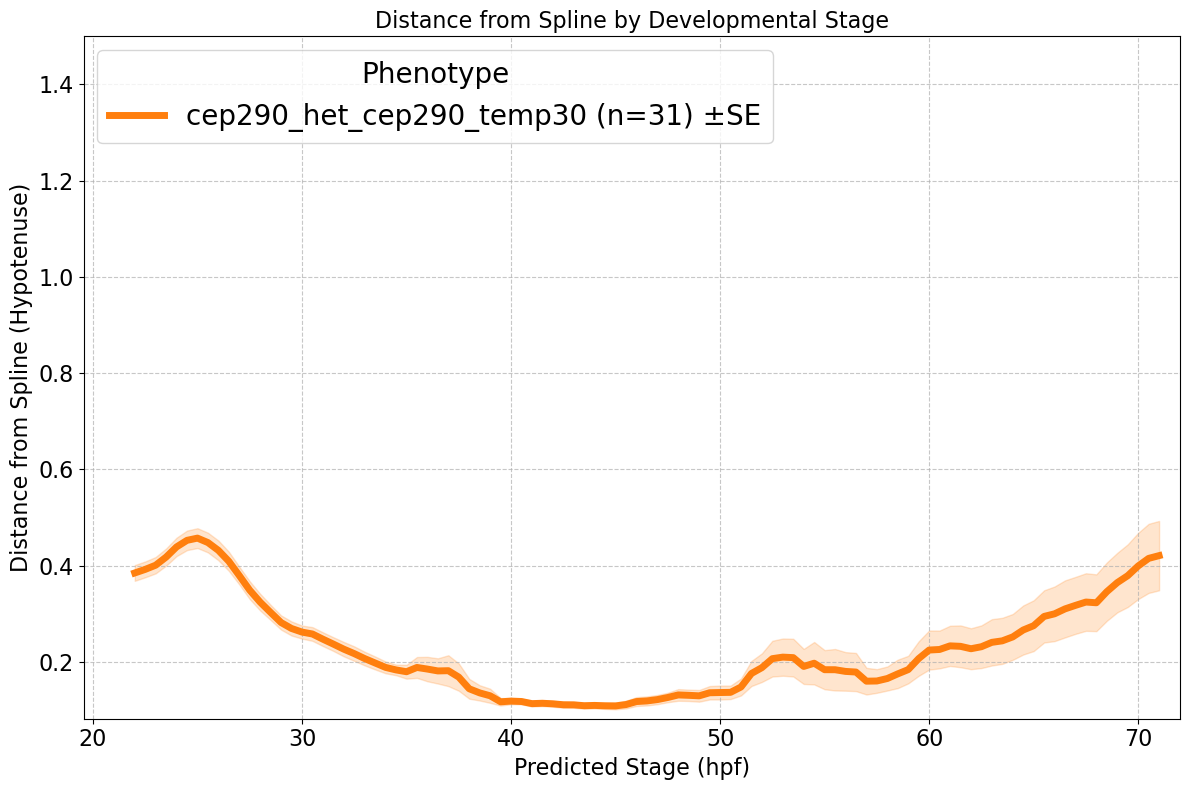

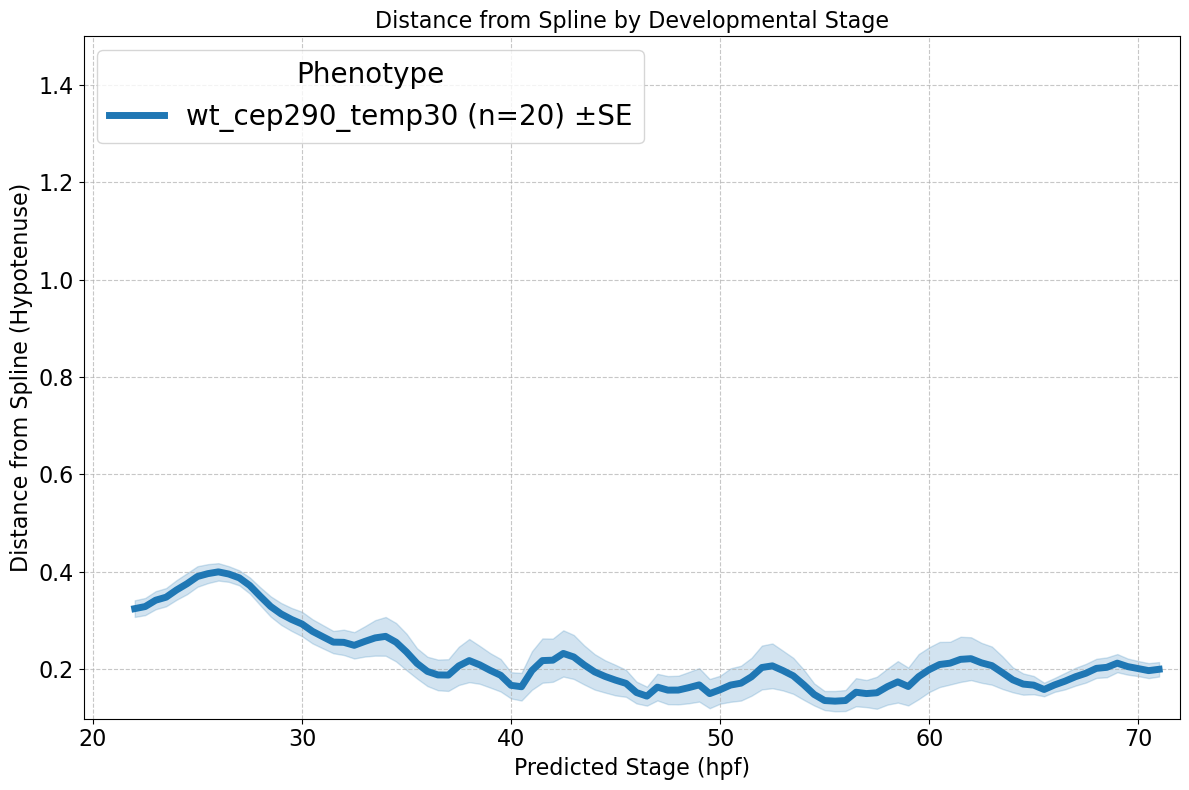

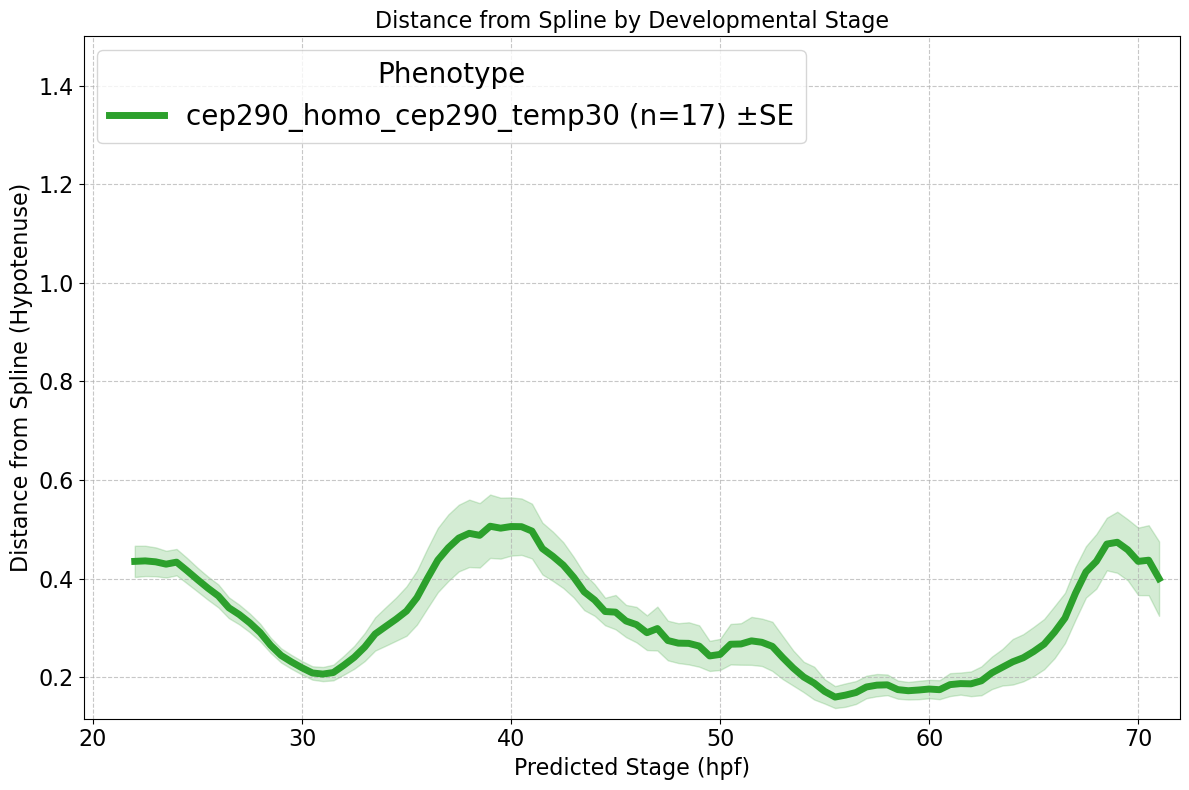

In [25]:

# # Example usage:
target_phenotypes = ['cep290_het_cep290_temp30', 'wt_cep290_temp30', 'cep290_homo_cep290_temp30']

cep290_cross_colors = {
    'cep290_het_cep290_temp30': '#ff7f0e',  # tab10 orange
    'wt_cep290_temp30': '#1f77b4',         # tab10 blue
    'cep290_homo_cep290_temp30': '#2ca02c'  # tab10 green
}


# Line plot with individual embryos and averages
for target in target_phenotypes:

    plot_hypotenuse_over_stage(
        df=df_augmented_projec_wt,
        phenotypes_to_include=[target],
        window_size=5,
        min_hpf=None,
        max_hpf=72,
        plot_variance_bars=True,
        max_distance=1.5,
        phenotype_colors=cep290_cross_colors,
        title_fontsize=16,
        label_fontsize=16,
        tick_fontsize=16,
        legend_fontsize=20,
        plot_individual_embryos=False,

        # save_path=os.path.join(plot_dir,"hypotenuse_stage_plot_v2.pdf")
    )

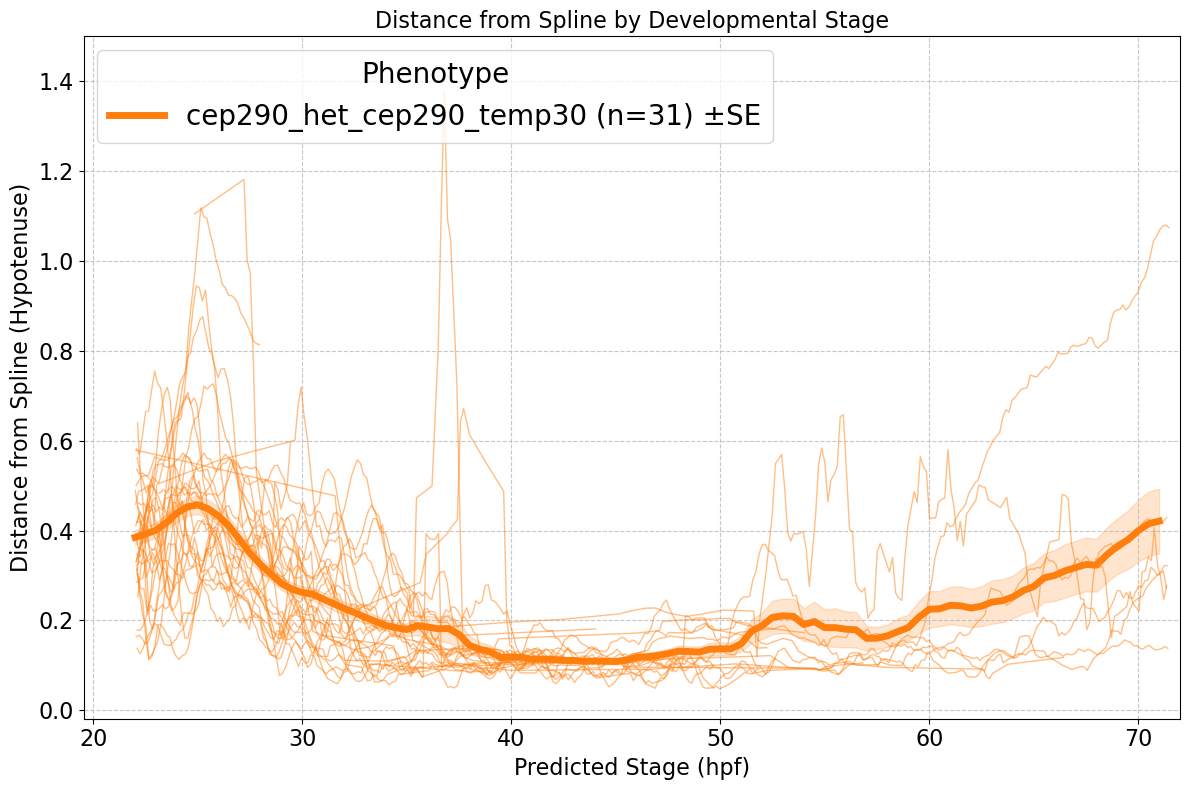

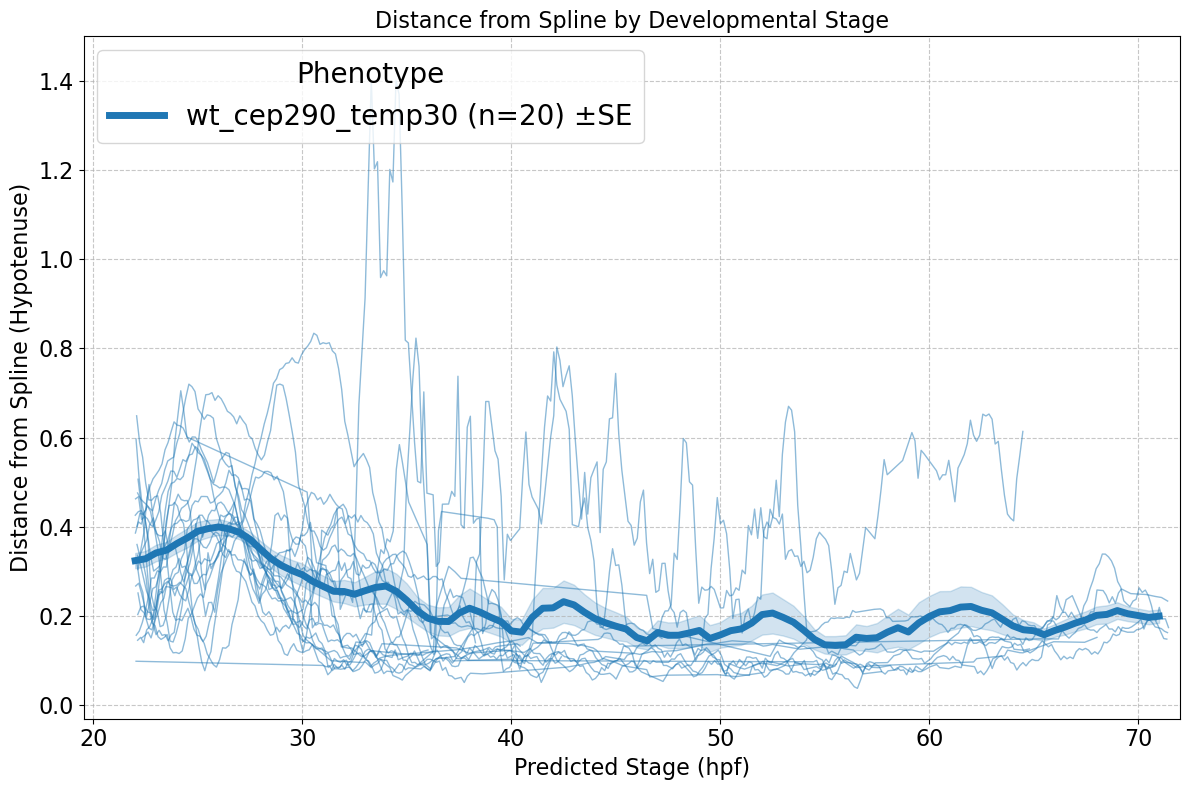

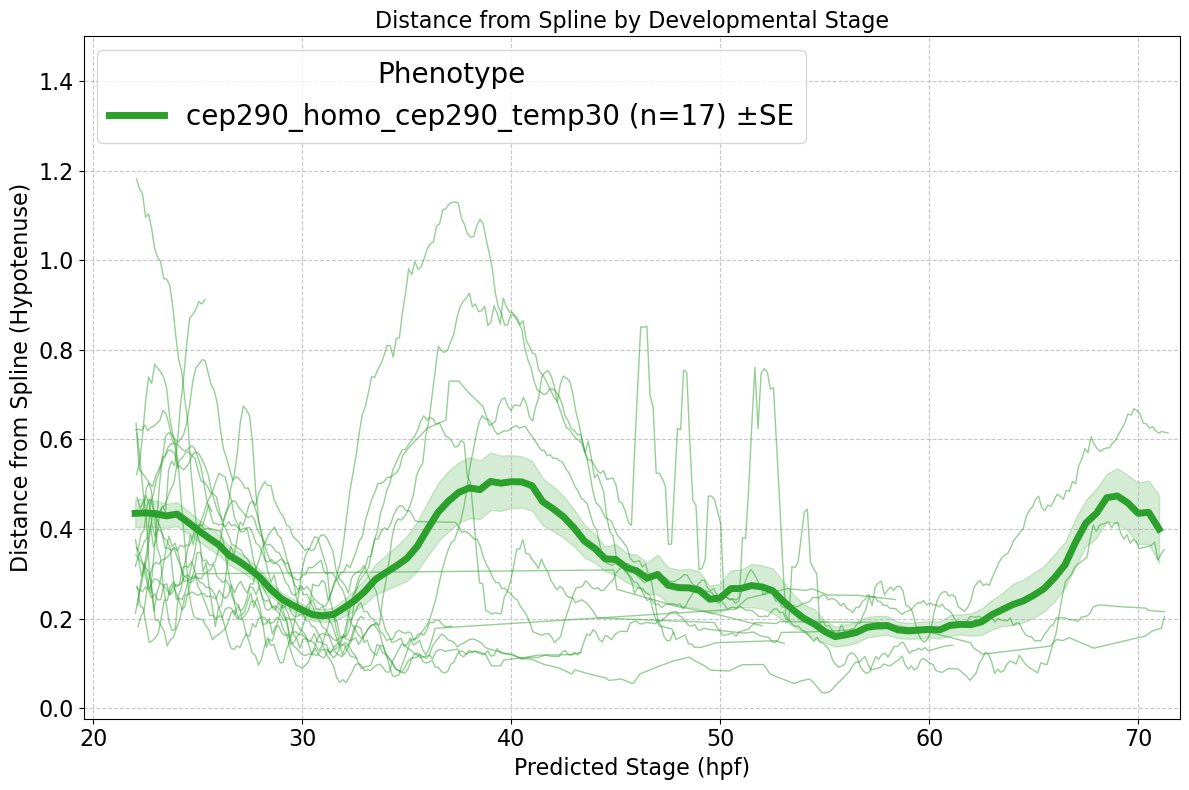

In [26]:

# # Example usage:
target_phenotypes = ['cep290_het_cep290_temp30', 'wt_cep290_temp30', 'cep290_homo_cep290_temp30']

cep290_cross_colors = {
    'cep290_het_cep290_temp30': '#ff7f0e',  # tab10 orange
    'wt_cep290_temp30': '#1f77b4',         # tab10 blue
    'cep290_homo_cep290_temp30': '#2ca02c'  # tab10 green
}


# Line plot with individual embryos and averages
for target in target_phenotypes:

    plot_hypotenuse_over_stage(
        df=df_augmented_projec_wt,
        phenotypes_to_include=[target],
        window_size=5,
        min_hpf=None,
        max_hpf=72,
        plot_variance_bars=True,
        max_distance=1.5,
        phenotype_colors=cep290_cross_colors,
        title_fontsize=16,
        label_fontsize=16,
        tick_fontsize=16,
        legend_fontsize=20,
        plot_individual_embryos=True,

        # save_path=os.path.join(plot_dir,"hypotenuse_stage_plot_v2.pdf")
    )

In [11]:
def plot_pca_with_splines(df_points, df_splines, 
                         point_opacity=0.7, 
                         save_dir=None, 
                         downsample_dict=None, 
                         color_dict=None,
                         title="PCA Plot with Splines",
                         min_snip_count=20,
                         phenotypes_of_interest=None,
                         show_splines=True,
                         spline_width=6):
    """
    Plot PCA points and their splines with customizable options.
    
    Parameters:
    -----------
    df_points : pandas.DataFrame
        DataFrame containing the original points with columns 'PCA_1', 'PCA_2', 'PCA_3', 'phenotype',
        'embryo_id', and 'snip_id'
    df_splines : pandas.DataFrame
        DataFrame containing the spline data with columns 'PCA_1', 'PCA_2', 'PCA_3', and 'phenotype'
    point_opacity : float, optional (default=0.7)
        Opacity value for the points (0.0 to 1.0)
    save_dir : str, optional (default=None)
        Directory to save the plot. If None, the plot will not be saved.
    downsample_dict : dict, optional (default=None)
        Dictionary with phenotypes as keys and fraction of points to keep as values.
        Example: {'wt_temp22': 0.5} will randomly keep 50% of 'wt_temp22' points.
    color_dict : dict, optional (default=None)
        Dictionary with phenotypes as keys and colors as values.
        If None, colors will be automatically assigned.
    title : str, optional (default="PCA Plot with Splines")
        Title of the plot
    min_snip_count : int, optional (default=20)
        Minimum number of snips required for an embryo to be included in the plot.
        Embryos with fewer snips will be filtered out.
    phenotypes_of_interest : list, optional (default=None)
        List of phenotypes to include in the plot. If None, all phenotypes are included.
        Example: ['wt_temp22', 'mutant_temp30']
    show_splines : bool, optional (default=True)
        Whether to display spline traces. If False, only points will be shown.
    spline_width : int, optional (default=6)
        Width/thickness of the spline lines. Higher values create thicker lines.
    
    Returns:
    --------
    fig : plotly.graph_objects.Figure
        The generated Plotly figure
    """
    import plotly.graph_objects as go
    import os
    
    # Filter by phenotypes of interest first
    if phenotypes_of_interest is not None:
        df_points = df_points[df_points['phenotype'].isin(phenotypes_of_interest)].copy()
        if df_splines is not None:
            df_splines = df_splines[df_splines['phenotype'].isin(phenotypes_of_interest)].copy()
    
    # Filter embryos based on snip count
    embryo_counts = df_points.groupby('embryo_id')['snip_id'].count()
    valid_embryos = embryo_counts[embryo_counts >= min_snip_count].index.tolist()
    
    # Filter out embryos with too few snips
    removed_embryos = set(df_points['embryo_id'].unique()) - set(valid_embryos)
    if removed_embryos:
        print(f"Removed {len(removed_embryos)} embryos with fewer than {min_snip_count} snips.")
    
    # Filter dataframe to include only valid embryos
    filtered_df = df_points[df_points['embryo_id'].isin(valid_embryos)].copy()
    
    # Check if any data remains after filtering
    if filtered_df.empty:
        print("Warning: No data remaining after filtering. Please check your phenotypes_of_interest and min_snip_count parameters.")
        # Return empty figure
        fig = go.Figure()
        fig.update_layout(title="No Data Available")
        return fig
    
    # Helper function to convert hex/named color to rgba with opacity
    def color_with_opacity(color_str, opacity):
        """Convert a color to an rgba string with the given opacity"""
        if color_str.startswith('#'):  # Hex color
            hex_color = color_str.lstrip('#')
            if len(hex_color) == 6:
                r, g, b = [int(hex_color[i:i+2], 16) for i in (0, 2, 4)]
                return f'rgba({r}, {g}, {b}, {opacity})'
            else:
                # Fall back to a basic case if hex format is unexpected
                return f'rgba(100, 100, 100, {opacity})'
        elif color_str.startswith('rgb'):  # RGB or RGBA color
            if color_str.startswith('rgba'):
                # Already has opacity, just modify the opacity part
                return color_str.rsplit(',', 1)[0] + f', {opacity})'
            else:  # RGB format, convert to RGBA
                return color_str.replace('rgb', 'rgba').rstrip(')') + f', {opacity})'
        else:  # Named color, use a default opacity approach
            # For simplicity, we'll use semi-transparent blue for any named colors
            # This is a simplification - for production you might want a more robust solution
            standard_colors = {
                'blue': 'rgba(0, 0, 255, {0})',
                'green': 'rgba(0, 128, 0, {0})',
                'red': 'rgba(255, 0, 0, {0})',
                'cyan': 'rgba(0, 255, 255, {0})',
                'magenta': 'rgba(255, 0, 255, {0})',
                'yellow': 'rgba(255, 255, 0, {0})',
                'purple': 'rgba(128, 0, 128, {0})',
                'orange': 'rgba(255, 165, 0, {0})',
                'brown': 'rgba(165, 42, 42, {0})',
                'pink': 'rgba(255, 192, 203, {0})',
                'gray': 'rgba(128, 128, 128, {0})',
                'darkgreen': 'rgba(0, 100, 0, {0})'
            }
            
            if color_str.lower() in standard_colors:
                return standard_colors[color_str.lower()].format(opacity)
            else:
                # Default for any unrecognized color name
                return f'rgba(100, 100, 100, {opacity})'
    
    # Get unique phenotypes (after filtering)
    phenotypes = filtered_df['phenotype'].unique()
    
    # Create color dictionary if not provided
    if color_dict is None:
        # Default color palette - can be extended with more colors if needed
        default_colors = [
            '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
            '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
            # Add more colors here if you want more distinct colors
        ]
        # Using modulo ensures we cycle through colors if we have more phenotypes than colors
        color_dict = {phenotype: default_colors[i % len(default_colors)] for i, phenotype in enumerate(phenotypes)}
        
        # Check if we have more phenotypes than colors (will cause color reuse)
        if len(phenotypes) > len(default_colors):
            print(f"Warning: More phenotypes ({len(phenotypes)}) than colors ({len(default_colors)}). Some colors will be reused.")
    
    # Create figure
    fig = go.Figure()
    
    # Process each phenotype
    for phenotype in phenotypes:
        # Filter points for this phenotype
        points = filtered_df[filtered_df['phenotype'] == phenotype].copy()
        
        # Apply downsampling if specified
        if downsample_dict is not None and phenotype in downsample_dict:
            fraction = downsample_dict[phenotype]
            if 0 < fraction < 1:
                # Randomly select a fraction of the points
                points = points.sample(frac=fraction, random_state=42)
        
        # Get color for this phenotype
        color = color_dict.get(phenotype, '#1f77b4')  # Default to blue if not in color_dict
        
        # Add points to plot with hover data
        fig.add_trace(
            go.Scatter3d(
                x=points['PCA_1'],
                y=points['PCA_2'],
                z=points['PCA_3'],
                mode='markers',
                marker=dict(
                    size=4,
                    color=color,
                    opacity=point_opacity
                ),
                name=f"{phenotype} (points)",
                showlegend=True,
                hovertemplate='<b>%{text}</b><br>PCA_1: %{x:.3f}<br>PCA_2: %{y:.3f}<br>PCA_3: %{z:.3f}<extra></extra>',
                text=[f"Embryo: {row['embryo_id']}<br>Snip: {row['snip_id']}<br>Phenotype: {row['phenotype']}" 
                      for _, row in points.iterrows()]
            )
        )
        
        # Add spline for this phenotype (only if show_splines is True)
        if show_splines and df_splines is not None:
            spline = df_splines[df_splines['phenotype'] == phenotype]
            if not spline.empty:
                fig.add_trace(
                    go.Scatter3d(
                        x=spline['PCA_1'],
                        y=spline['PCA_2'],
                        z=spline['PCA_3'],
                        mode='lines',
                        line=dict(
                            color=color,
                            width=spline_width
                        ),
                        name=f"{phenotype} (spline)",
                        showlegend=True
                    )
                )
    
    # Update layout
    fig.update_layout(
        scene=dict(
            xaxis_title='PCA 1',
            yaxis_title='PCA 2',
            zaxis_title='PCA 3'
        ),
        title=title,
        margin=dict(l=0, r=0, b=0, t=40),
        legend=dict(
            x=0.01,
            y=0.99,
            bordercolor="Black",
            borderwidth=1
        )
    )
    
    # Save figure if save_dir is provided
    if save_dir is not None:
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        fig.write_html(os.path.join(save_dir, f"{title.replace(' ', '_')}.html"))
        fig.write_image(os.path.join(save_dir, f"{title.replace(' ', '_')}.png"))
    
    return fig


# 

In [18]:
# Downsample to reduce point density (especially helpful for large datasets)
downsample_dict = {
    'wt_temp30': 0.05   # Keep 5% of wt_temp30 points
}

color_dict = {
    'wt_temp30': 'darkblue',
    'cep290_het_cep290_temp30': '#ff7f0e',
    'wt_cep290_temp30': '#1f77b4',
    'cep290_homo_cep290_temp30': '#2ca02c'
}


# Create and save the plot
fig = plot_pca_with_splines(
    df_points  = df_augmented_projec_wt,
    df_splines = pert_splines,
    point_opacity=0.65,  # Make points slightly transparent
    downsample_dict=downsample_dict,
    color_dict=color_dict,
    save_dir=plot_dir,
    title="Cep290 Phenotypes In Morphology Space With Null Mutant and WT Siblings Reference",
    phenotypes_of_interest = list(color_dict.keys())[-2:],
    show_splines= False,
    spline_width=15,
)



Removed 2 embryos with fewer than 20 snips.


In [17]:
# Create and save the plot
fig = plot_pca_with_splines(
    df_points  = df_augmented_projec_wt,
    df_splines = pert_splines,
    point_opacity=0.65,  # Make points slightly transparent
    downsample_dict=downsample_dict,
    color_dict=color_dict,
    save_dir=plot_dir,
    title="Cep290 Phenotypes In Morphology Space With Null Mutant and WT Siblings and WT Ctrl Reference",
    phenotypes_of_interest = [list(color_dict.keys())[i] for i in [0, 2, 3]],
    show_splines= True,
    spline_width=15,
)

Removed 83 embryos with fewer than 20 snips.
